# Open AI Caribbean Challenge: Mapping Disaster Risk from Aerial Imagery

- Alex Sissoko (ams2508), Pranav Shrestha (ps2958)

In [1]:
import os
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.set_printoptions(precision=3, sign=' ', floatmode='fixed')
print(tf.test.is_gpu_available(), tf.version.VERSION)

True 2.0.0


In [2]:
DATA_DIR   = os.path.join(os.getcwd(), "data")
OUTPUT_DIR = os.path.join(os.getcwd(), "output")
CLASS_LABELS = ['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

# Utility functions
Path     = os.path.join
DataPath = lambda path: os.path.join(DATA_DIR, path)

def mkdir_p(directory):
    if not os.path.exists(directory):
        os.mkdir(directory)

In [3]:
df = pd.read_csv("new_train.csv")
df['id']    = df['id'] + ".tif"
df['label'] = df['label'].apply(lambda x: ['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other'][x])
df.head()

,id,label,filelabel
0,7a3f2a10.tif,concrete_cement,3
1,7a1f731e.tif,irregular_metal,3
2,7a424ad8.tif,healthy_metal,3
3,7a3edc5e.tif,healthy_metal,3
4,7a303a6e.tif,healthy_metal,3


In [4]:
train_df = df.sample(frac=0.9)
valid_df = df.loc[df.index.difference(train_df.index), :]

In [5]:
train_df.index.size, valid_df.index.size, train_df.index.union(valid_df.index).size

(13383, 1487, 14870)

In [6]:
train_filenames  = train_df['id'].values
train_filelabels = train_df['filelabel'].values
train_labels     = train_df['label'].values

print("File labels ", train_df['filelabel'].value_counts())
print("Labels    : ", train_df["label"].value_counts())
train_filelabels = tf.keras.utils.to_categorical(train_filelabels)

valid_filenames  = valid_df['id'].values
valid_filelabels = valid_df['filelabel'].values
valid_labels     = valid_df['label'].values

print("File labels ", valid_df['filelabel'].value_counts())
print("Labels    : ", valid_df["label"].value_counts())
valid_filelabels = tf.keras.utils.to_categorical(valid_filelabels)

File labels  2    5373
3    3926
0    3038
4     907
1     139
Name: filelabel, dtype: int64
Labels    :  healthy_metal      6645
irregular_metal    4733
concrete_cement    1242
incomplete          589
other               174
Name: label, dtype: int64
File labels  2    622
3    435
0    313
4     97
1     20
Name: filelabel, dtype: int64
Labels    :  healthy_metal      736
irregular_metal    508
concrete_cement    145
incomplete          79
other               19
Name: label, dtype: int64


In [7]:
img_width, img_height = 128, 128

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    vertical_flip=True,
#     fill_mode='reflect'
)


train_generator  = train_datagen.flow_from_dataframe(
    train_df, directory="data/verified_aligned_df/",
    x_col="id",  y_col="label", classes = CLASS_LABELS,
    target_size=(img_width, img_height),
    color_mode='rgb', batch_size=len(train_df), shuffle=False,
    class_mode="categorical"
)

valid_generator  = train_datagen.flow_from_dataframe(
    valid_df, directory="data/verified_aligned_df/",
    x_col="id",  y_col="label", classes = CLASS_LABELS,
    target_size=(img_width, img_height),
    color_mode='rgb', batch_size=len(train_df), shuffle=False,
    class_mode="categorical"
)

# Split using https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
print("Label codes   : ", train_generator.class_indices)
print("Training data : ", train_generator.n)
print("Validation data : ", valid_generator.n)

Found 13383 validated image filenames belonging to 5 classes.
Found 1487 validated image filenames belonging to 5 classes.
Label codes   :  {'concrete_cement': 0, 'other': 4, 'healthy_metal': 1, 'irregular_metal': 3, 'incomplete': 2}
Training data :  13383
Validation data :  1487


In [8]:
train_images, train_labels = train_generator.next()

In [9]:
valid_images, valid_labels = valid_generator.next()

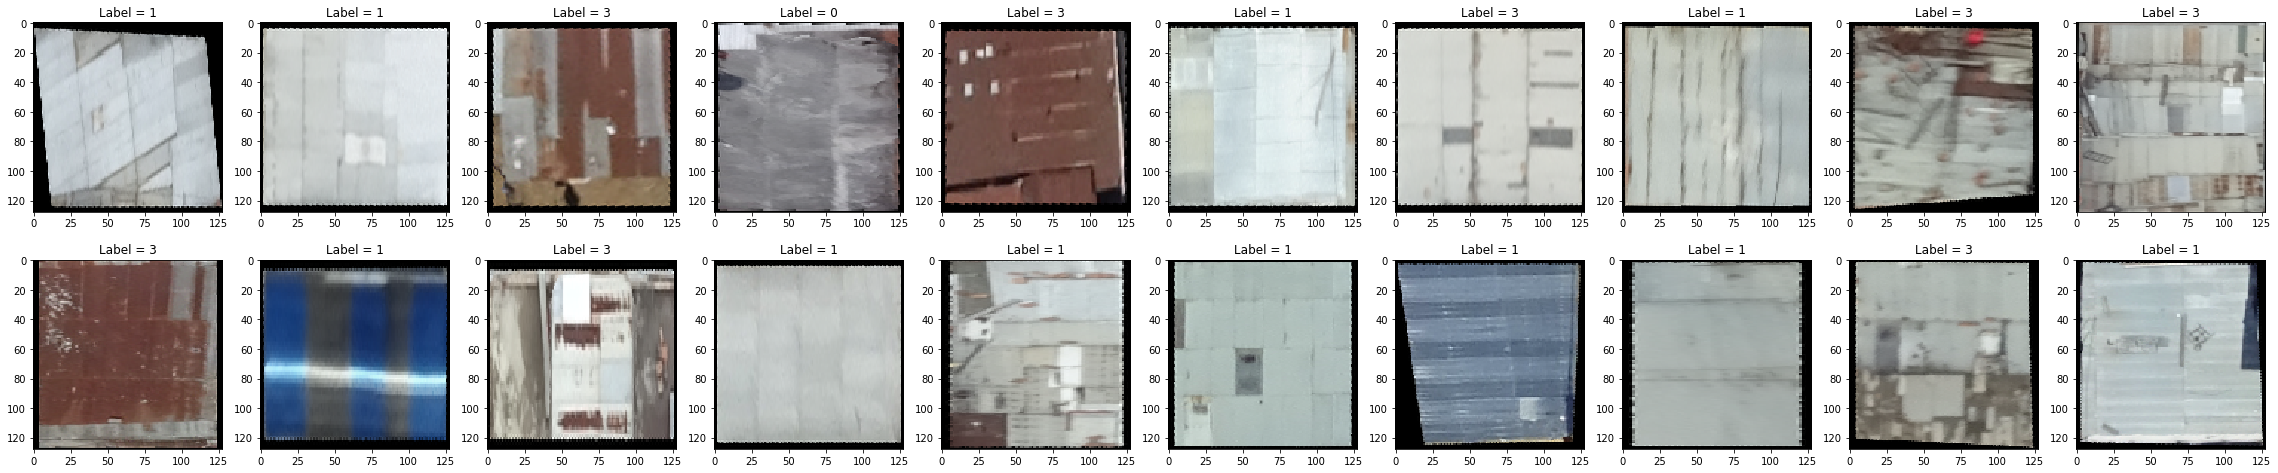

In [10]:
fig, axs = plt.subplots(2, 10, figsize=(40, 8))

for img_data, label, ax in zip(train_images, train_labels, axs.flat):
    ax.imshow(img_data)
    ax.set_title("Label = " + str(label.argmax()))

# Simple CNN

In [11]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.losses as losses

In [12]:
tf.keras.backend.clear_session()

In [53]:
input_img  = Input(shape=(img_width, img_height, 3), name="InputImage")
input_file = Input(shape=(5, ), name="InputLabel")

x = input_img

greyscale = Lambda(tf.image.rgb_to_grayscale)(x)
dy, dx = Lambda(tf.image.image_gradients)(greyscale)

hsv = Lambda(tf.image.rgb_to_hsv)(x)

x = Concatenate()([hsv, dx, dy])

x = Conv2D(16, (3, 3), activation=ReLU())(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)

x = Conv2D(32, (3, 3), activation=ReLU())(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)

x = Conv2D(64, (3, 3), activation=ReLU())(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)

x = Flatten()(x)
x = Dense(256, activation=ReLU())(x)
x = Dropout(0.5)(x)

x = Dense(16, activation=ReLU())(x)

x = Concatenate()([x, input_file])
x = Dense(5, kernel_initializer='ones', activation='softmax')(x)

model = Model([input_img, input_file], x, name="SimpleCNN")

model.summary()

In [54]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [56]:
model.fit(
    x=[train_images, train_filelabels], y=train_labels,
    batch_size=128, epochs=10, shuffle=True,
    validation_data=[[valid_images, valid_filelabels], valid_labels]
)

Train on 13383 samples, validate on 1487 samples
Epoch 1/10
13383/13383 [==============================] - 10s 741us/sample - loss: 0.6679 - acc: 0.7427 - val_loss: 0.7580 - val_acc: 0.6893
Epoch 2/10
13383/13383 [==============================] - 10s 733us/sample - loss: 0.6415 - acc: 0.7538 - val_loss: 0.8014 - val_acc: 0.6711
Epoch 3/10
13383/13383 [==============================] - 10s 735us/sample - loss: 0.6263 - acc: 0.7594 - val_loss: 0.7498 - val_acc: 0.7001
Epoch 4/10
13383/13383 [==============================] - 10s 733us/sample - loss: 0.6164 - acc: 0.7595 - val_loss: 0.7617 - val_acc: 0.6940
Epoch 5/10
13383/13383 [==============================] - 10s 734us/sample - loss: 0.6122 - acc: 0.7659 - val_loss: 0.6926 - val_acc: 0.7243
Epoch 6/10
13383/13383 [==============================] - 10s 734us/sample - loss: 0.5974 - acc: 0.7689 - val_loss: 0.7471 - val_acc: 0.7041
Epoch 7/10
13383/13383 [==============================] - 10s 735us/sample - loss: 0.5774 - acc: 0.7788 -

In [72]:
model.save("cnn_augmented.h5")

# Generate testing output

In [57]:
test_df = pd.read_csv("new_test.csv")
test_df['id'] = test_df['id'] + ".tif"
test_df.head()

,id,filelabel
0,7a459b34.tif,3
1,7a4b61ea.tif,4
2,7a4e8258.tif,3
3,7a511018.tif,2
4,7a4f5a34.tif,0


In [58]:
test_filenames  = test_df['id'].values
test_filelabels = test_df['filelabel'].values

test_filelabels = tf.keras.utils.to_categorical(test_filelabels)

In [59]:
img_width, img_height = 128, 128

# this is the augmentation configuration we will use for training
test_datagen = ImageDataGenerator(
    rescale=1/255.,
    fill_mode='reflect',
#     preprocessing_function = tf.image.rgb_to_hsv,
)

test_generator  = test_datagen.flow_from_dataframe(
    test_df, directory="data/test_aligned/test_images/",
    x_col="id", 
    target_size=(img_width, img_height),
    color_mode='rgb', batch_size=len(test_df), shuffle=False,
    class_mode=None
)

# Split using https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
print("Training data : ", test_generator.n)

Found 7325 validated image filenames.
Training data :  7325


In [60]:
test_images = test_generator.next()

In [61]:
test_labels = model.predict(x=[test_images, test_filelabels])

In [62]:
tmp = train_labels.sum(0)
tmp / tmp.sum()

array([ 0.093,  0.497,  0.044,  0.354,  0.013], dtype=float32)

In [63]:
tmp = valid_labels.sum(0)
tmp / tmp.sum()

array([ 0.098,  0.495,  0.053,  0.342,  0.013], dtype=float32)

In [64]:
tmp = test_labels.sum(0)
tmp / tmp.sum()

array([ 0.126,  0.350,  0.085,  0.419,  0.020], dtype=float32)

In [65]:
output = test_labels

In [66]:
output.max(), output.min(), output.max(1).mean(), -np.log(output.max(1).mean())

(0.99656713, 8.168378e-08, 0.6831182, 0.38108733)

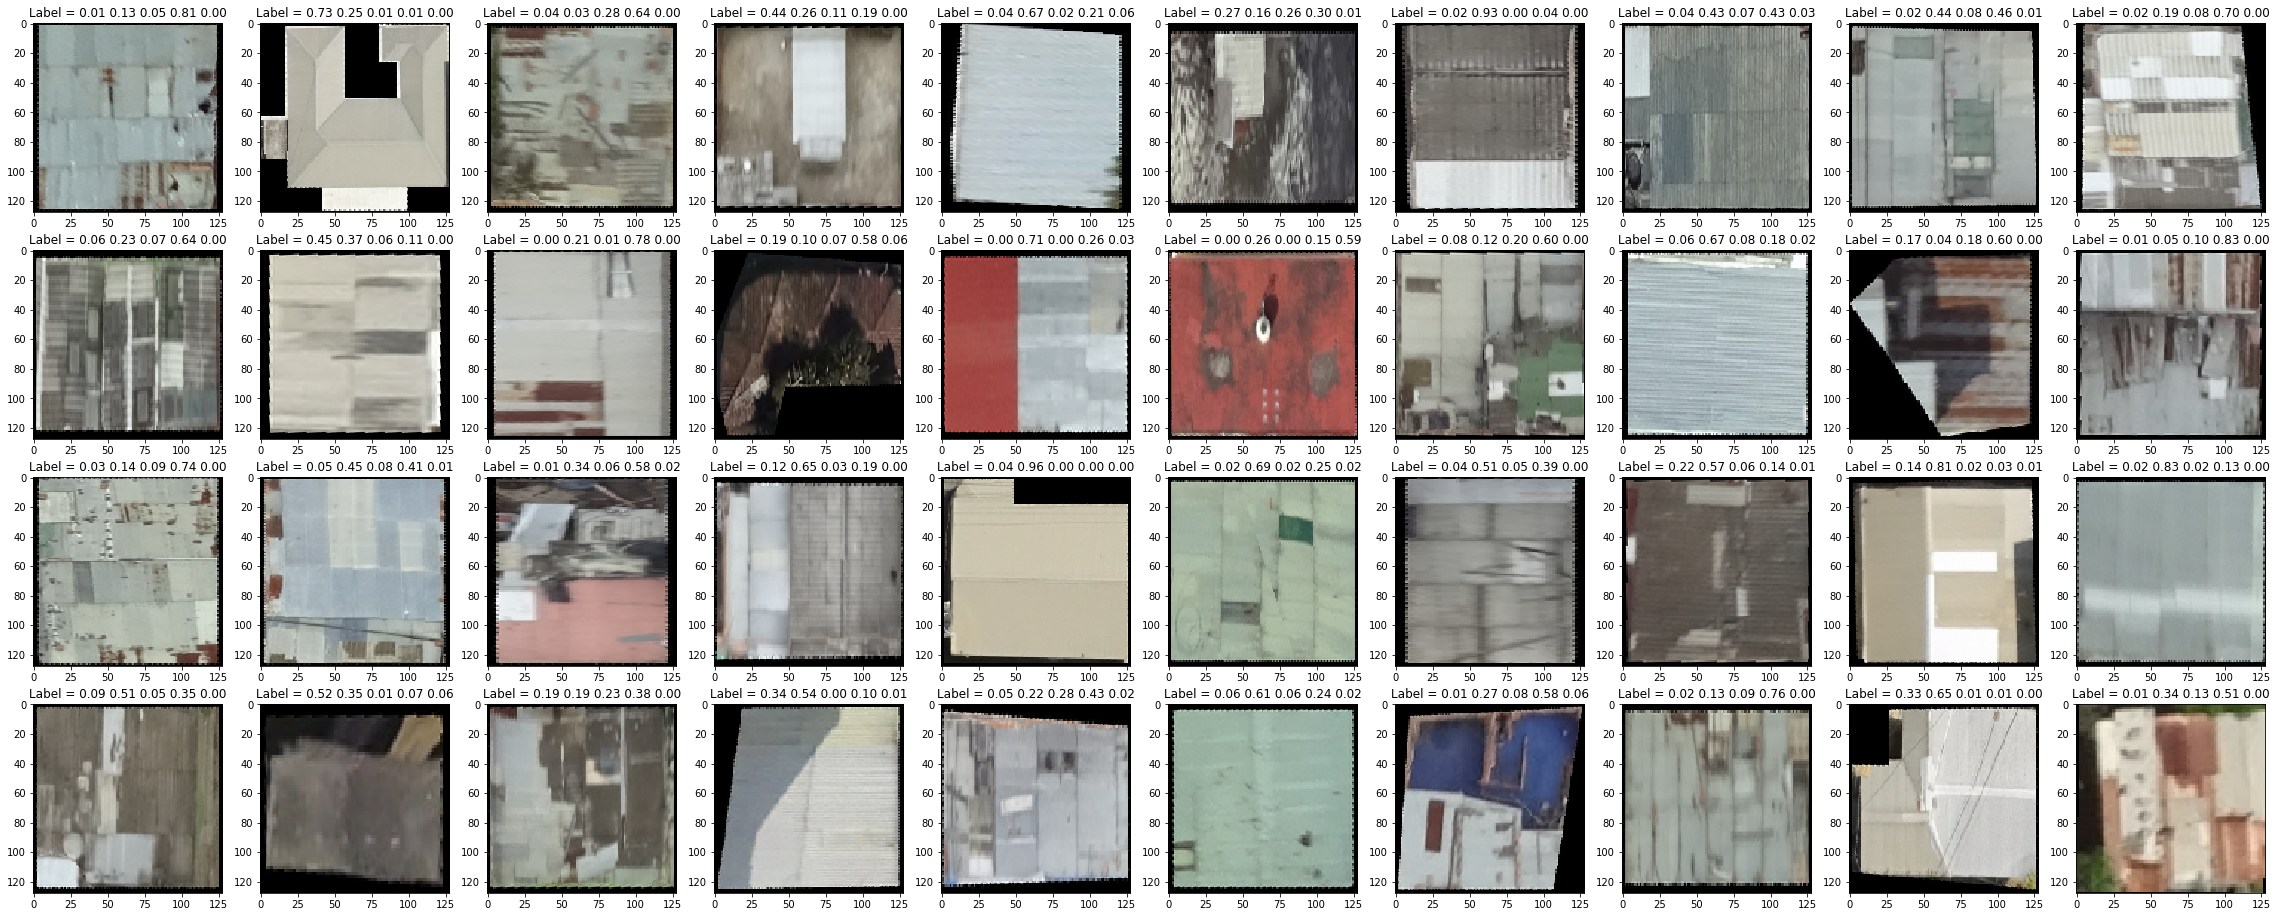

In [67]:
fig, axs = plt.subplots(4, 10, figsize=(40, 16))

for img_data, label, ax in zip(test_images, test_labels, axs.flat):
    ax.imshow(img_data)
    ax.set_title("Label = %.2f %.2f %.2f %.2f %.2f" % tuple(label))

# Generate submission

In [68]:
fids = map(lambda x: os.path.basename(x).split('.')[0], test_generator.filepaths)

df = pd.DataFrame(test_labels, index=[filename[:-4] for filename in test_filenames], columns=CLASS_LABELS)
df.index.name = 'id'

In [69]:
df.head()

,concrete_cement,healthy_metal,incomplete,irregular_metal,other
id,,,,,
7a459b34,0.006725,0.128296,0.054284,0.810299,0.000396
7a4b61ea,0.728012,0.249827,0.014877,0.006973,0.000312
7a4e8258,0.043736,0.030357,0.281714,0.643838,0.000356
7a511018,0.438543,0.258679,0.113792,0.188243,0.000742
7a4f5a34,0.037557,0.671565,0.016728,0.210802,0.063349


In [70]:
submission_format = pd.read_csv('submission_format.csv', index_col='id')
df = df.reindex(submission_format.index)
df.head()

,concrete_cement,healthy_metal,incomplete,irregular_metal,other
id,,,,,
7a4d630a,0.025365,0.847070,0.019749,0.097670,0.010146
7a4bbbd6,0.025131,0.928843,0.001482,0.043933,0.000612
7a4ac744,0.035232,0.700353,0.022235,0.239850,0.002330
7a4881fa,0.260143,0.157411,0.110183,0.471457,0.000806
7a4aa4a8,0.055937,0.305645,0.115491,0.516712,0.006215


In [71]:
df.to_csv("cnn_with_town_modified.csv")